In [24]:
#install MNE library
!pip install mne
#import necessary libraries
import numpy as np
import scipy.io
import mne
import matplotlib.pyplot as plt
import os


In [25]:
#mounting google drive and loading data
from google.colab import drive
drive.mount('/content/drive')
file_path='/content/drive/MyDrive/Subject_A_Train.mat'
mat_data=scipy.io.loadmat(file_path)
print(mat_data)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Mon Nov 29 08:14:54 2004', '__version__': '1.0', '__globals__': [], 'Signal': array([[[ 8.0849998e-02, -1.7930571e+01, -9.2669497e+00, ...,
         -1.9443050e+01, -1.0342620e+01, -1.4575340e+01],
        [-2.2476299e+00, -1.7676010e+01, -6.4597502e+00, ...,
         -1.7911850e+01, -8.0227804e+00, -1.3052780e+01],
        [ 7.5837302e+00, -1.4875850e+01, -3.3973501e+00, ...,
         -1.4083850e+01, -4.1563802e+00, -9.7538996e+00],
        ...,
        [-2.6567310e+01, -1.4366730e+01, -2.4068550e+01, ...,
          5.0561500e+00, -1.3210200e+00,  3.9491401e+00],
        [-2.1651630e+01, -1.2330250e+01, -2.0750950e+01, ...,
          9.7294998e-01, -2.0943000e+00,  1.1577801e+00],
        [-2.2169069e+01, -1.5130410e+01, -2.4068550e+01, ...,
         -1.3238500e+00, -4.6718998e+00, -1.6335800

In [26]:
#extracting EEG signal
data_signals=mat_data['Signal']
print(data_signals.shape)

(85, 7794, 64)


In [27]:
#reshaping EEG signal
data_signals= np.transpose(data_signals, axes=(0, 2, 1))
data_signals= data_signals.reshape(64, 85*7794)
data_signals=data_signals*1e-6

In [28]:
#processing marker channels
Flashing=(mat_data['Flashing']).flatten()
StimulusCode=(mat_data['StimulusCode']).flatten()
#ensuring lengths of the processed signal and markers are consistent.
print(data_signals.shape,Flashing.shape,mat_data['StimulusCode'].shape)


(64, 662490) (662490,) (85, 7794)


In [29]:
#constructing MNE events
diff_flash = np.diff(Flashing)
onset_indices = np.where(diff_flash == 1)[0] + 1
event_ids = StimulusCode[onset_indices]
events = np.column_stack([onset_indices, np.zeros(len(onset_indices), int), event_ids])
print(events)


[[4.20000e+01 0.00000e+00 1.10000e+01]
 [8.40000e+01 0.00000e+00 3.00000e+00]
 [1.26000e+02 0.00000e+00 1.00000e+01]
 ...
 [6.62130e+05 0.00000e+00 1.20000e+01]
 [6.62172e+05 0.00000e+00 8.00000e+00]
 [6.62214e+05 0.00000e+00 7.00000e+00]]


In [30]:
#creating MNE raw object
channels_names=[f"EEG{n:03}" for n in range(1, 65)]
sampling_freq=200 #in Hertz
channel_types=["eeg"]*64
info=mne.create_info(channels_names,ch_types=channel_types,sfreq=sampling_freq)
raw=mne.io.RawArray(data_signals,info)
print(info)


Creating RawArray with float64 data, n_channels=64, n_times=662490
    Range : 0 ... 662489 =      0.000 ...  3312.445 secs
Ready.
<Info | 7 non-empty values
 bads: []
 ch_names: EEG001, EEG002, EEG003, EEG004, EEG005, EEG006, EEG007, EEG008, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 200.0 Hz
>


Effective window size : 10.240 (s)
Plotting power spectral density (dB=True).


/tmp/ipython-input-3025709402.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = raw.compute_psd().plot()


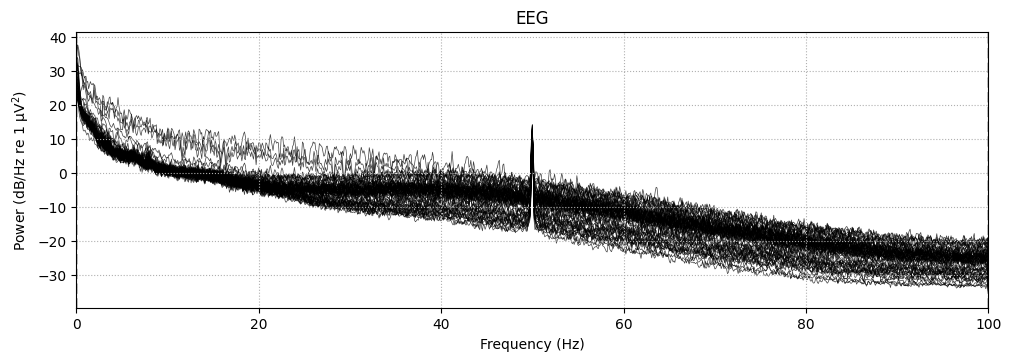

In [31]:
#visualsing data b4 filtering.
#power spectral density
fig = raw.compute_psd().plot()

In [32]:
#apply band pass filter
raw=raw.filter(l_freq=1,h_freq=49,fir_design='firwin')


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 661 samples (3.305 s)



In [33]:
#downsampling the data
raw=raw.resample(sfreq=100)

Effective window size : 20.480 (s)
Plotting power spectral density (dB=True).


/tmp/ipython-input-2324248387.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = raw.compute_psd().plot()


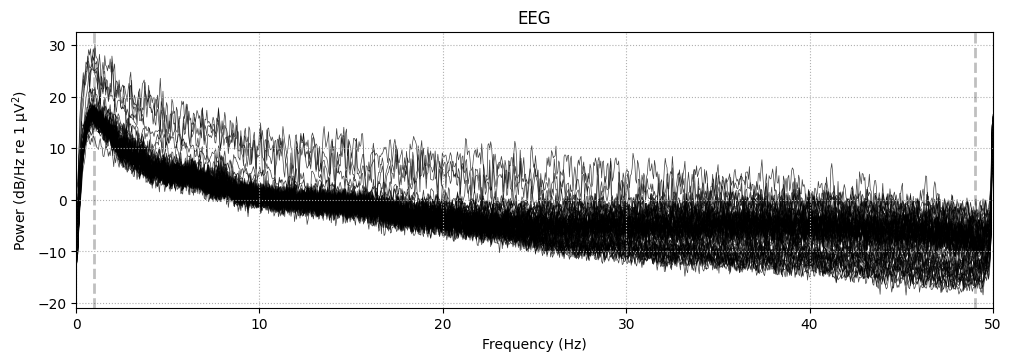

In [34]:
#visualizing data after filtering
fig = raw.compute_psd().plot()

In [35]:
#renaming and assigning montage
mapping={'EEG001': 'Fpz', 'EEG002': 'Fp1', 'EEG003': 'Fp2', 'EEG004': 'AF7', 'EEG005': 'AF3',
    'EEG006': 'AFz', 'EEG007': 'AF4', 'EEG008': 'AF8', 'EEG009': 'F7', 'EEG010': 'F5',
    'EEG011': 'F3', 'EEG012': 'F1', 'EEG013': 'Fz', 'EEG014': 'F2', 'EEG015': 'F4',
    'EEG016': 'F6', 'EEG017': 'F8', 'EEG018': 'FT9', 'EEG019': 'FT7', 'EEG020': 'FC5',
    'EEG021': 'FC3', 'EEG022': 'FC1', 'EEG023': 'FCz', 'EEG024': 'FC2', 'EEG025': 'FC4',
    'EEG026': 'FC6', 'EEG027': 'FT8', 'EEG028': 'FT10', 'EEG029': 'T9', 'EEG030': 'T7',
    'EEG031': 'C5', 'EEG032': 'C3', 'EEG033': 'C1', 'EEG034': 'Cz', 'EEG035': 'C2',
    'EEG036': 'C4', 'EEG037': 'C6', 'EEG038': 'T8', 'EEG039': 'T10', 'EEG040': 'TP9',
    'EEG041': 'TP7', 'EEG042': 'CP5', 'EEG043': 'CP3', 'EEG044': 'CP1', 'EEG045': 'CPz',
    'EEG046': 'CP2', 'EEG047': 'CP4', 'EEG048': 'CP6', 'EEG049': 'TP8', 'EEG050': 'TP10',
    'EEG051': 'P9', 'EEG052': 'P7', 'EEG053': 'P5', 'EEG054': 'P3', 'EEG055': 'P1',
    'EEG056': 'Pz', 'EEG057': 'P2', 'EEG058': 'P4', 'EEG059': 'P6', 'EEG060': 'P8',
    'EEG061': 'P10', 'EEG062': 'PO9', 'EEG063': 'PO7', 'EEG064': 'PO3'}
raw=raw.rename_channels(mapping);
montage=mne.channels.make_standard_montage('standard_1005')
raw=raw.set_montage(montage)


In [36]:
#initializing and fitting ica
ica= mne.preprocessing.ICA(n_components=15,random_state=97)
ica.fit(raw)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 23.8s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,27 iterations on raw data (331245 samples)
ICA components,15
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


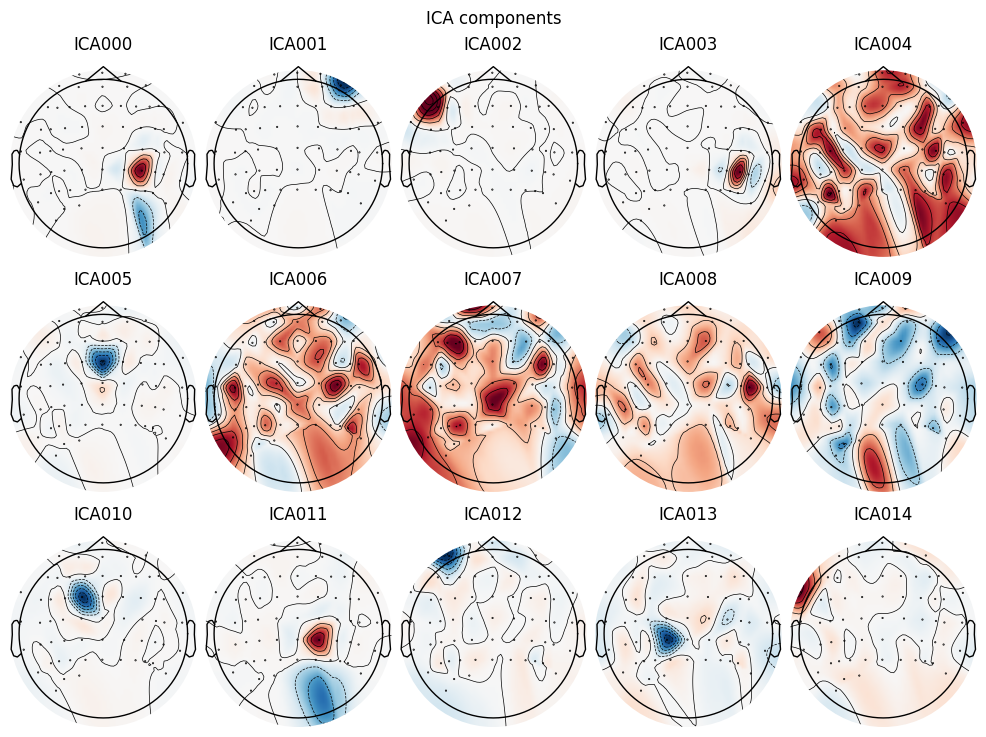

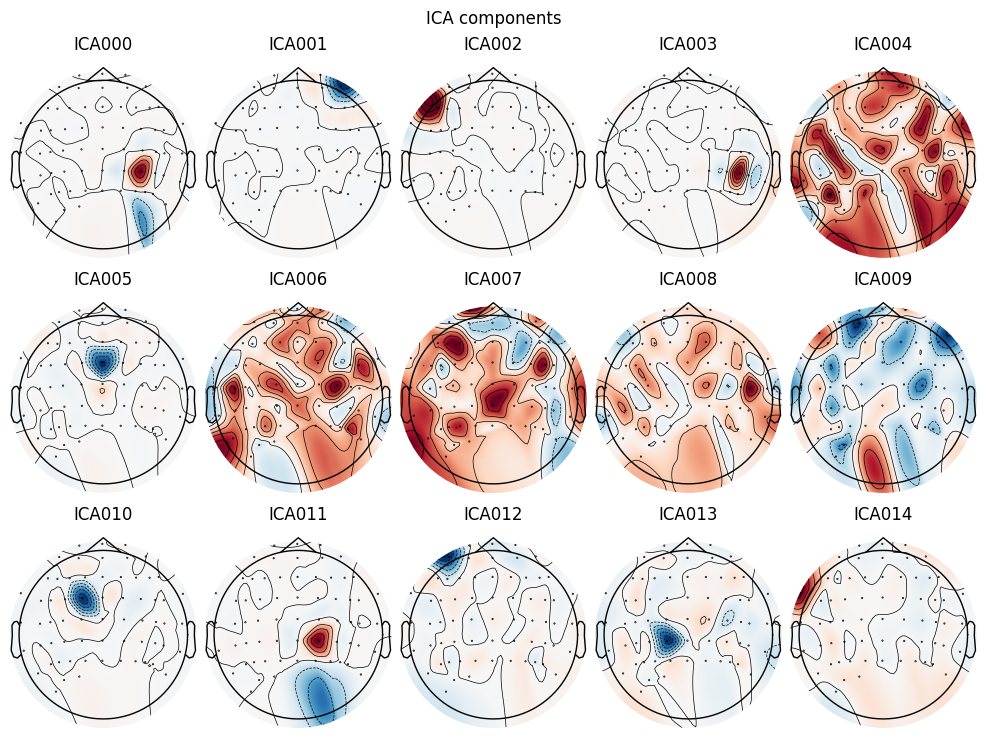

In [37]:
#plotting ica components
ica.plot_components()

yaha se doubt hai

In [38]:
#Identifying and Excluding Artifact Components
ica.exclude=[]

In [39]:
#Applying ICA to Remove Artifacts
ica.apply(raw)

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components


<RawArray | 64 x 331245 (3312.4 s), ~161.8 MiB, data loaded>

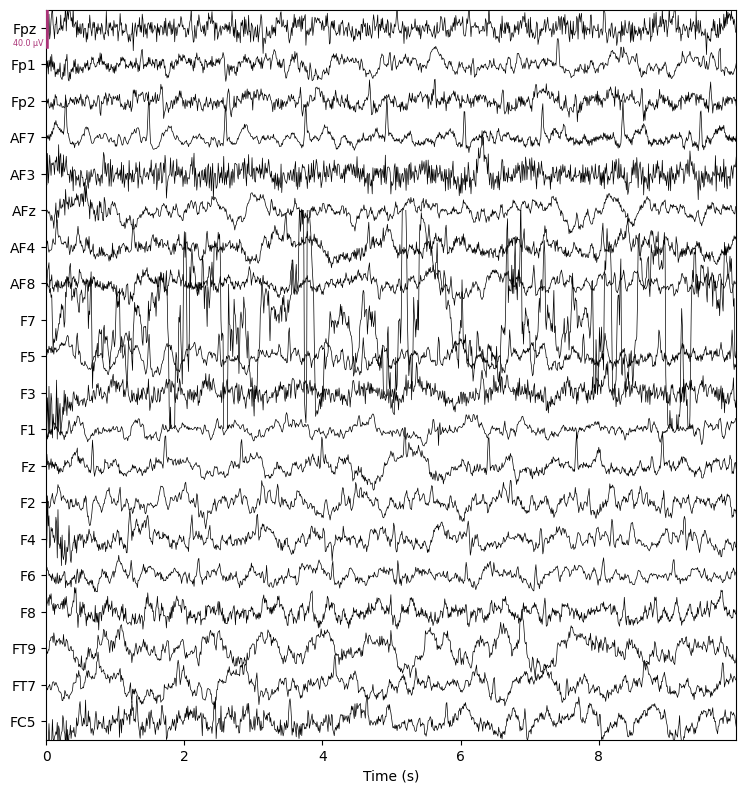

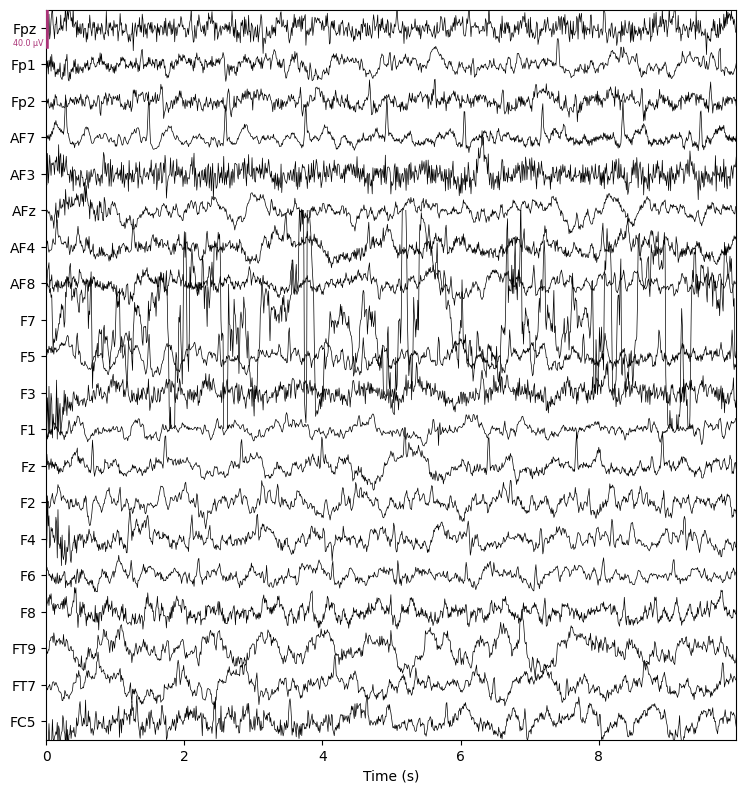

In [40]:
 #Visualizing Clean Data
 raw.plot(show_scrollbars=False,title='Data AFTER removing Blinks')

In [41]:
# Preparing Events for Epoching
StimulusType=mat_data['StimulusType']
events[:,2]=
event_id_map = {'Non-Target': 1, 'Target': 2}
print(events)

SyntaxError: invalid syntax (ipython-input-3611715761.py, line 3)

In [ ]:
#creating epochs
epochs = mne.Epochs(raw, events, tmin=-0.3, tmax=0.7,preload=True)
epochs.drop_bad()

In [ ]:
#computing evoked responses
evoked = epochs.average(by_event_type=True)

In [ ]:
#visualizing P300 response
evoked_target = epochs['target'].average()
evoked_non_target = epochs['non-target'].average()
evokeds = [evoked_target, evoked_non_target]
mne.viz.plot_compare_evokeds(evokeds, picks='Pz', colors=['blue', 'red'])
